In [1]:
import random
import copy
import time
import pandas as pd
import numpy as np
import gc
import re
import torch
from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm
tqdm.pandas(desc='Progress')
from collections import Counter
from nltk import word_tokenize

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
from sklearn.metrics import f1_score
import os 

# cross validation and metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from torch.optim.optimizer import Optimizer

from sklearn.preprocessing import StandardScaler
from multiprocessing import  Pool
from functools import partial
import numpy as np
from sklearn.decomposition import PCA
import torch as t
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

C:\Users\Dyuti\anaconda3\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [33]:
# Import Train Dataset and provide location of the CSV file
trainDf = pd.read_csv("C:/Users/Dyuti/Documents/Text/train.csv")
# #Import Test Dataset and provide location of the CSV file
testDf = pd.read_csv("C:/Users/Dyuti/Documents/Text/test.csv")

In [34]:
trainDf

,Unnamed: 0,Question_Asked,Agency
0,0,eForm 16 and V103,ICA
1,1,What is the latest new update of number plate,LTA
2,2,need to know further about Benefit In kind,IRAS IIT
3,3,how to filling individual tax return,IRAS IIT
4,4,can not reopen XBRL zipped file,ACRA
...,...,...,...
353920,353920,Search fees for notice of assessment,IRAS IIT
353921,353921,How do I did fix an appointment to see the tax...,IRAS IIT
353922,353922,I have make an appointment can I collect my pa...,ICA
353923,353923,hi in how many pixels should the photo for app...,ICA


In [35]:
testDf

,Unnamed: 0,Question_Asked,Agency
0,0,how to excuse ippt,MINDEF
1,1,How to refer wild animals found in public or p...,AVA
2,2,Hi can i check if the Talent Area of each Seco...,MOE
3,3,how to find courses and get funding support,SSG
4,4,AIS extension,IRAS IIT
...,...,...,...
88477,88477,i wanna ask about JAE,MOE
88478,88478,HI Can i sent in my car for inspection without...,LTA
88479,88479,IRAS Help line number,IRAS IIT
88480,88480,How do I declare rental income for HDB flat on...,IRAS IIT


In [36]:
#Max Length of Question Asked in Train
trainDf['len'] = trainDf['Question_Asked'].apply(lambda s : len(s))
max(trainDf.len)

250

In [37]:
#Max Length of Question Asked in Test
testDf['len'] = testDf['Question_Asked'].apply(lambda s : len(s))
max(testDf.len)

244

In [38]:
#Frequency of Questions across Agencies in Train
count_trainDf = trainDf[['Agency','Question_Asked']].groupby('Agency').aggregate({'Question_Asked':'count'}).reset_index().sort_values('Question_Asked',ascending=False)
count_trainDf

,Agency,Question_Asked
4,IRAS IIT,59829
2,ICA,58427
5,LTA,48374
0,ACRA,43587
8,SPF,35222
6,MINDEF,32252
9,SSG,23794
7,MOE,20389
3,IRAS GST,16819
1,AVA,15232


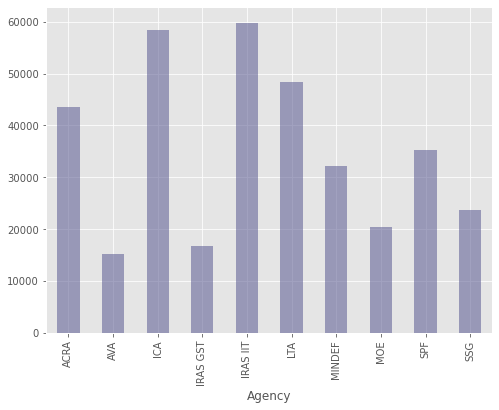

In [52]:
# Plot Bar Graph to see Question Distribution Across Agencies and provide location to export
fig = plt.figure(figsize=(8,6))
plot1 = trainDf.groupby('Agency').Question_Asked.count().plot.bar(ylim=0,color=(0.4, 0.4, 0.6, 0.6))
plt.savefig("C:/Users/Dyuti/Documents/Text/fig1.png")

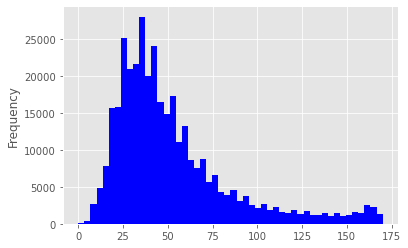

In [42]:
#Distribution of Question asked in Train Dataset by length of each Question provide location to export
fig2 = trainDf['len'].plot.hist(x = "Length of Questions",bins=50,color = "blue",range=[0, 170])
plt.savefig("C:/Users/Dyuti/Documents/Text/fig2.png")

In [63]:
#Functions for cleaning Text
import re

def clean_text(text):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(pattern, '', text)
    text = text.strip(' ')
    return text

def clean_numbers(text):
    if bool(re.search(r'\d', text)):
        text = re.sub('[0-9]{5,}', '#####', text)
        x = re.sub('[0-9]{4}', '####', text)
        x = re.sub('[0-9]{3}', '###', text)
        x = re.sub('[0-9]{2}', '##', text)
    return text

In [64]:
#Cleaning Train Dataset
# lower the text
trainDf["Question_Asked"] = trainDf["Question_Asked"].apply(lambda text: text.lower())

# Clean the text
trainDf["Question_Asked"] = trainDf["Question_Asked"].apply(lambda text: clean_text(text))

# Clean numbers
trainDf["Question_Asked"] = trainDf["Question_Asked"].apply(lambda text: clean_numbers(text))

In [65]:
trainDf.head()

,Unnamed: 0,Question_Asked,Agency,len
0,0,eform and v,ICA,17
1,1,what is the latest new update of number plate,LTA,45
2,2,need to know further about benefit in kind,IRAS IIT,42
3,3,how to filling individual tax return,IRAS IIT,36
4,4,can not reopen xbrl zipped file,ACRA,31


In [66]:
#Cleaning Test Dataset
# lower the text
testDf["Question_Asked"] = testDf["Question_Asked"].apply(lambda x: x.lower())

# Clean the text
testDf["Question_Asked"] = testDf["Question_Asked"].apply(lambda x: clean_text(x))

# Clean numbers
testDf["Question_Asked"] = testDf["Question_Asked"].apply(lambda x: clean_numbers(x))

In [67]:
testDf.head()

,Unnamed: 0,Question_Asked,Agency,len
0,0,how to excuse ippt,MINDEF,18
1,1,how to refer wild animals found in public or p...,AVA,58
2,2,hi can i check if the talent area of each seco...,MOE,112
3,3,how to find courses and get funding support,SSG,43
4,4,ais extension,IRAS IIT,13


In [68]:
#Remove Stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english')
trainDf['Question_Asked'] = trainDf['Question_Asked'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
testDf['Question_Asked'] =  testDf['Question_Asked'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [69]:
testDf.head()

,Unnamed: 0,Question_Asked,Agency,len
0,0,excuse ippt,MINDEF,18
1,1,refer wild animals found public private place,AVA,58
2,2,hi check talent area secondary schools updated...,MOE,112
3,3,find courses get funding support,SSG,43
4,4,ais extension,IRAS IIT,13


In [70]:
#Defining Train and Test Independent and Dependant variable datasets

X_train = trainDf.Question_Asked
X_test = testDf.Question_Asked

y_train= trainDf.Agency
y_test = testDf.Agency

In [86]:
# Run Multinomial Bayes

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

#Model Evaluation
print(classification_report(y_test, y_pred,target_names=testDf['Agency'].unique()))
testDf['Prediction_MNB'] = y_pred

              precision    recall  f1-score   support

      MINDEF       0.88      0.89      0.89     10899
         AVA       0.96      0.78      0.86      3805
         MOE       0.84      0.95      0.89     14605
         SSG       0.96      0.71      0.82      4207
    IRAS IIT       0.80      0.94      0.86     14943
        ACRA       0.89      0.91      0.90     12093
         LTA       0.93      0.79      0.86      8072
         ICA       0.97      0.81      0.88      5101
         SPF       0.89      0.87      0.88      8803
    IRAS GST       0.93      0.82      0.87      5954

    accuracy                           0.88     88482
   macro avg       0.91      0.85      0.87     88482
weighted avg       0.88      0.88      0.88     88482



In [87]:
# Run Linear SVC

from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)



y_pred_sgd = sgd.predict(X_test)


In [88]:
# Model Evaluation
print(classification_report(y_test, y_pred_sgd,target_names=testDf['Agency'].unique()))
testDf['Prediction_SG'] = y_pred_sgd

              precision    recall  f1-score   support

      MINDEF       0.83      0.89      0.86     10899
         AVA       0.92      0.71      0.80      3805
         MOE       0.83      0.94      0.89     14605
         SSG       0.95      0.72      0.82      4207
    IRAS IIT       0.81      0.90      0.85     14943
        ACRA       0.89      0.87      0.88     12093
         LTA       0.91      0.79      0.84      8072
         ICA       0.94      0.80      0.87      5101
         SPF       0.84      0.85      0.85      8803
    IRAS GST       0.88      0.81      0.84      5954

    accuracy                           0.86     88482
   macro avg       0.88      0.83      0.85     88482
weighted avg       0.86      0.86      0.86     88482



In [89]:
# Multinomial Logistic
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5,max_iter = 200)),
               ])
logreg.fit(X_train, y_train)



y_pred_log = logreg.predict(X_test)

C:\Users\Dyuti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [90]:
#Model Evaluation
print(classification_report(y_test, y_pred_log,target_names=testDf['Agency'].unique()))
testDf['Prediction_MLog'] = y_pred_log

              precision    recall  f1-score   support

      MINDEF       0.91      0.92      0.91     10899
         AVA       0.90      0.88      0.89      3805
         MOE       0.93      0.94      0.93     14605
         SSG       0.93      0.87      0.90      4207
    IRAS IIT       0.89      0.92      0.90     14943
        ACRA       0.93      0.92      0.92     12093
         LTA       0.89      0.89      0.89      8072
         ICA       0.93      0.90      0.91      5101
         SPF       0.92      0.89      0.91      8803
    IRAS GST       0.91      0.90      0.90      5954

    accuracy                           0.91     88482
   macro avg       0.91      0.90      0.91     88482
weighted avg       0.91      0.91      0.91     88482



In [91]:
testDf.head()

,Unnamed: 0,Question_Asked,Agency,len,category,Prediction_MNB,Prediction_SG,Prediction_MLog
0,0,excuse ippt,MINDEF,18,4,MINDEF,MINDEF,MINDEF
1,1,refer wild animals found public private place,AVA,58,8,AVA,ACRA,AVA
2,2,hi check talent area secondary schools updated...,MOE,112,9,MOE,MOE,MOE
3,3,find courses get funding support,SSG,43,6,SSG,SSG,SSG
4,4,ais extension,IRAS IIT,13,2,IRAS IIT,IRAS IIT,IRAS IIT


In [92]:
#export as CSV
testDf.to_csv("C:/Users/Dyuti/Documents/Text/ML_prediction.csv")